In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Nived Shah\AppData\Local\Temp\ipykernel_21228\555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_csv('HIGGS_smaller.csv')

y = df.iloc[:,0].to_numpy()
X = df.iloc[:,1:].to_numpy()

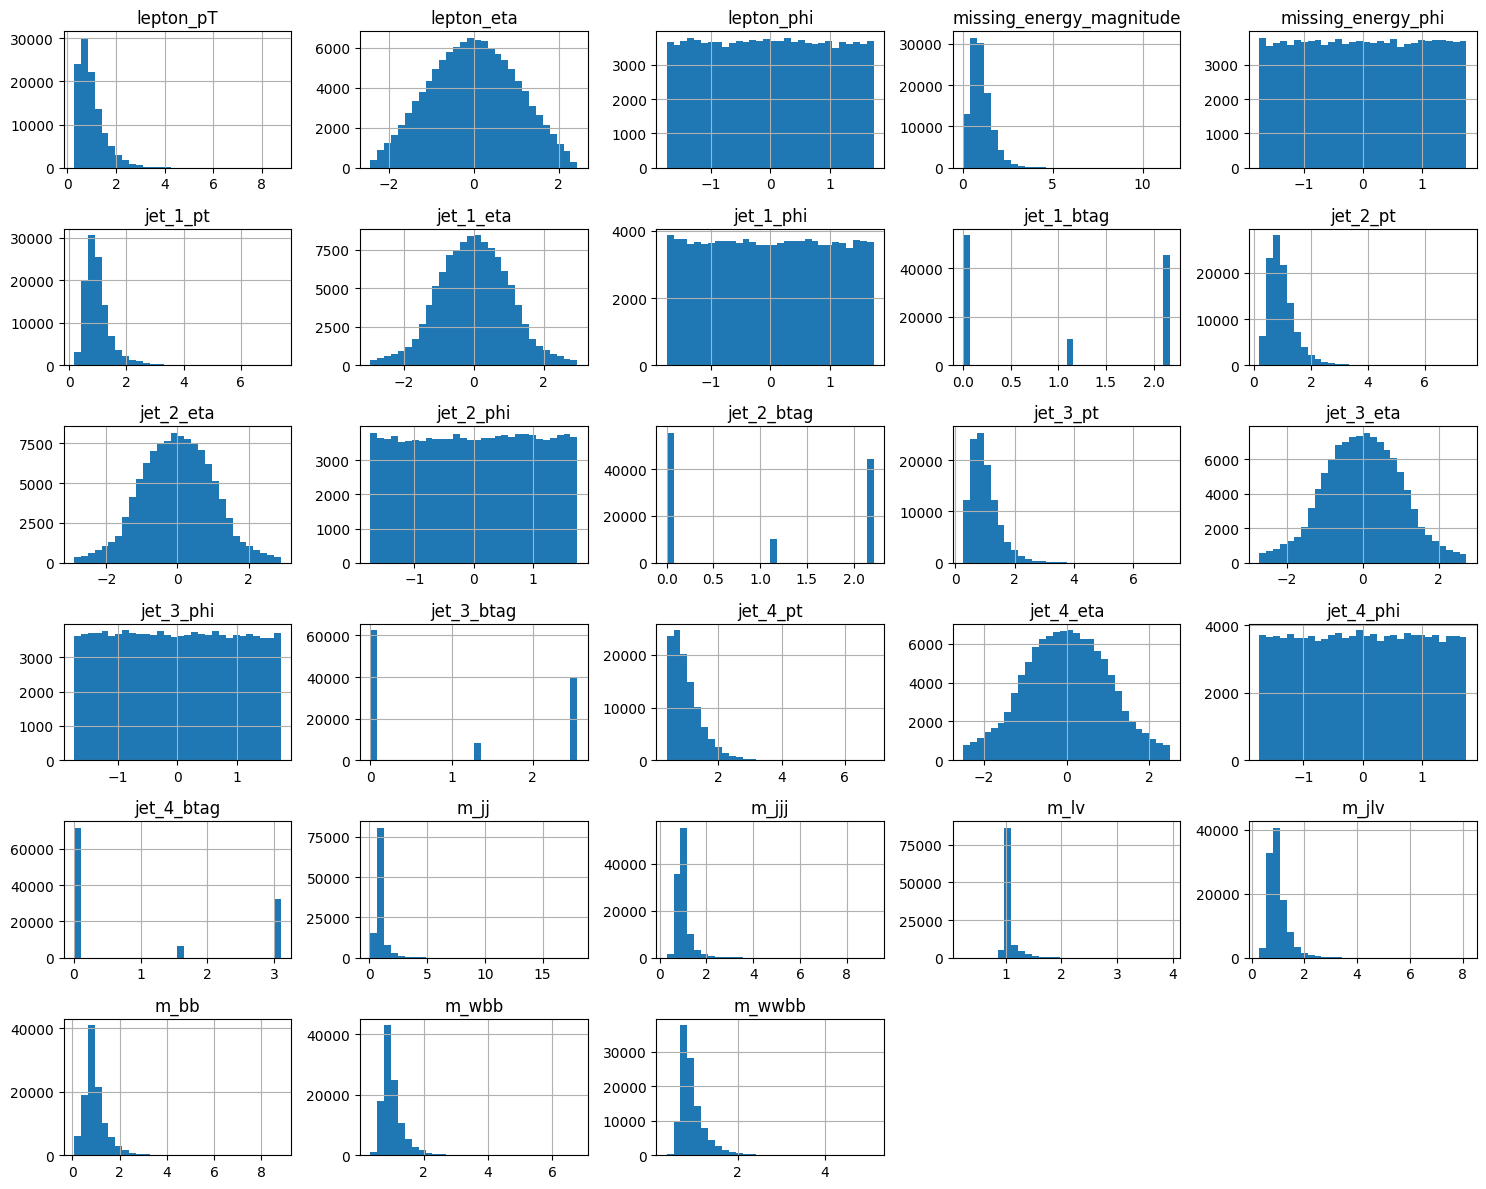

In [5]:
def add_column_names(X):
    column_names = [
        'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi',
        'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_btag',
        'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_btag',
        'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_btag',
        'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_btag',
        'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
    ]
    
    # Create a DataFrame and assign the column names
    X_df = pd.DataFrame(X, columns=column_names)
    return X_df

# Example usage
X_df = add_column_names(X)

# Now you can visualize histograms with column names attached
X_df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()


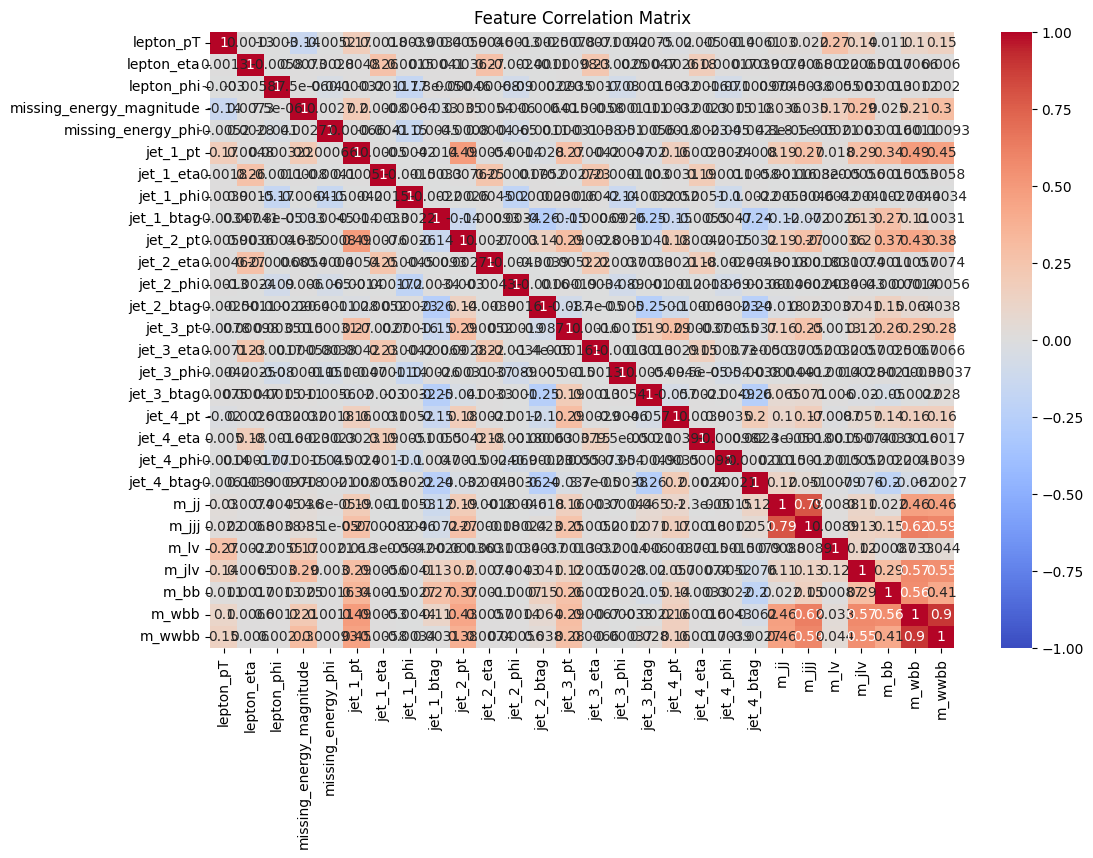

In [6]:
# Compute correlation matrix
corr_matrix = X_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


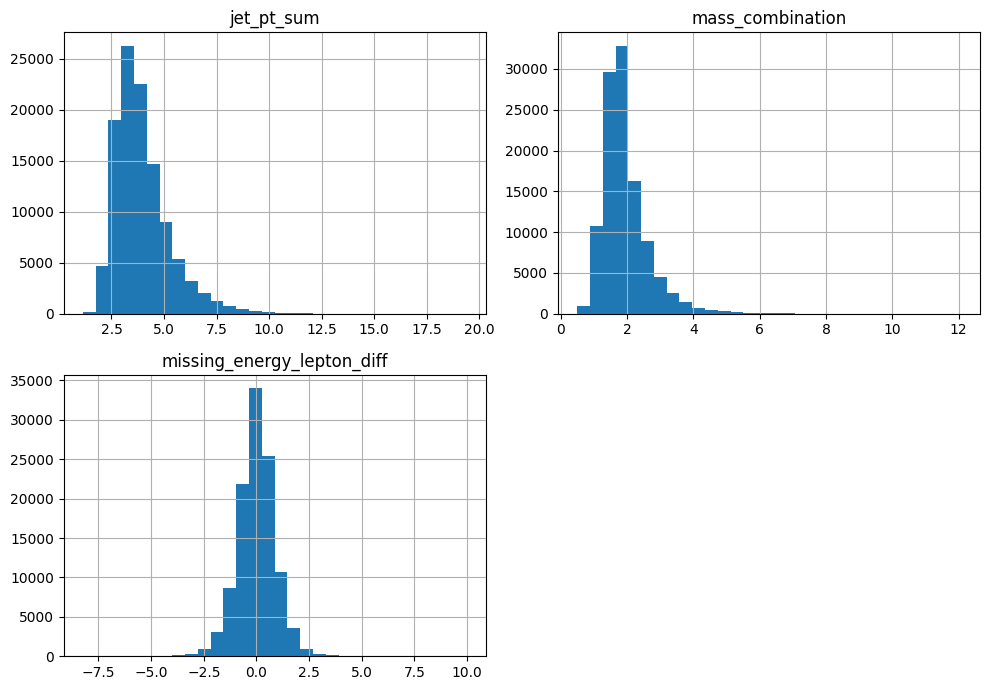

In [7]:
# Create new features based on domain knowledge
X_df['jet_pt_sum'] = X_df['jet_1_pt'] + X_df['jet_2_pt'] + X_df['jet_3_pt'] + X_df['jet_4_pt']
X_df['mass_combination'] = X_df['m_bb'] + X_df['m_wwbb']  # Combine masses of interest
X_df['missing_energy_lepton_diff'] = X_df['missing_energy_magnitude'] - X_df['lepton_pT']  # Example difference

# Now visualize the distribution of these new features
X_df[['jet_pt_sum', 'mass_combination', 'missing_energy_lepton_diff']].hist(figsize=(10, 7), bins=30)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = X_df.copy()

for column in X_scaled.columns:
    if X_scaled[column].min() > 0:
        X_scaled[column] = X_scaled[column] / X_scaled[column].mean()
    else:
        X_scaled[column] = scaler.fit_transform(X_scaled[column].values.reshape(-1, 1))

In [9]:
from sklearn.decomposition import PCA

# # Apply PCA to reduce dimensionality
pca = PCA(n_components=5)  # Choose number of components
X_pca = pca.fit_transform(X_scaled)

# # Plot explained variance by each principal component
# plt.figure(figsize=(8, 5))
# plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
# plt.title('Cumulative Explained Variance by PCA Components')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

# # Visualize the first two principal components
# plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, cmap='coolwarm')
# plt.title('PCA - First Two Principal Components')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()


In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(X_train.shape)

(88000, 5)


In [2]:
# SVM with Linear Kernel
svm_model = SVC(kernel='linear', probability=True)

In [ ]:
# Perform cross-validation to evaluate the SVM model
cross_val_scores = cross_val_score(svm_model, X_train, y_train, cv=5) 
print(f'Cross-Validation Accuracy: {np.mean(cross_val_scores):.2f} ± {np.std(cross_val_scores):.2f}')

In [ ]:
# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]  

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Report metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {roc_auc:.2f}')

# Scalability and Efficiency: Implementing SGD
# Using SGDClassifier for scalability with large datasets
sgd_model = make_pipeline(StandardScaler(), SGDClassifier(loss='log', random_state=42))
sgd_model.fit(X_train, y_train)

# Make predictions with the SGD model
y_pred_sgd = sgd_model.predict(X_test)
y_prob_sgd = sgd_model.predict_proba(X_test)[:, 1]

# Calculate classification metrics for SGD
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
precision_sgd = precision_score(y_test, y_pred_sgd)
recall_sgd = recall_score(y_test, y_pred_sgd)
f1_sgd = f1_score(y_test, y_pred_sgd)
roc_auc_sgd = roc_auc_score(y_test, y_prob_sgd)

# Report metrics for SGD
print("\nSGD Classifier Metrics:")
print(f'Accuracy: {accuracy_sgd:.2f}')
print(f'Precision: {precision_sgd:.2f}')
print(f'Recall: {recall_sgd:.2f}')
print(f'F1 Score: {f1_sgd:.2f}')
print(f'AUC: {roc_auc_sgd:.2f}')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    return accuracy, precision, recall, f1, roc_auc


In [ ]:
degree_list = [2, 3, 4]
poly_results = {}

for degree in degree_list:
    model = SVC(kernel='poly', degree=degree, probability=True)
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_test, y_test)
    poly_results[degree] = metrics
    print(f'Polynomial Kernel (Degree={degree}): Accuracy={metrics[0]:.2f}, Precision={metrics[1]:.2f}, Recall={metrics[2]:.2f}, F1 Score={metrics[3]:.2f}, AUC={metrics[4]:.2f}')

In [ ]:
# 2. RBF Kernel with Hyperparameter Tuning
gamma_values = [0.01, 0.1, 1, 10]
best_rbf_metrics = {}

for gamma in gamma_values:
    model = SVC(kernel='rbf', gamma=gamma, probability=True)
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_test, y_test)
    best_rbf_metrics[gamma] = metrics
    print(f'RBF Kernel (Gamma={gamma}): Accuracy={metrics[0]:.2f}, Precision={metrics[1]:.2f}, Recall={metrics[2]:.2f}, F1 Score={metrics[3]:.2f}, AUC={metrics[4]:.2f}')

In [ ]:
# 3. Custom Kernel: Hybrid Kernel (RBF + Linear)
def hybrid_kernel(X, Y):
    return 0.5 * (SVC(kernel='linear').fit(X, y).decision_function(X) + SVC(kernel='rbf').fit(X, y).decision_function(X))

# Wrap custom kernel for use in SVC
custom_model = SVC(kernel=hybrid_kernel, probability=True)
custom_model.fit(X_train, y_train)
custom_metrics = evaluate_model(custom_model, X_test, y_test)
print(f'Custom Hybrid Kernel: Accuracy={custom_metrics[0]:.2f}, Precision={custom_metrics[1]:.2f}, Recall={custom_metrics[2]:.2f}, F1 Score={custom_metrics[3]:.2f}, AUC={custom_metrics[4]:.2f}')

In [ ]:
# 4. Hyperparameter Tuning with Grid Search for all kernels
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

In [ ]:
# Polynomial kernel
poly_grid = GridSearchCV(SVC(kernel='poly', degree=3, probability=True), param_grid, scoring='roc_auc', cv=5)
poly_grid.fit(X_train, y_train)
best_poly = poly_grid.best_estimator_
poly_metrics = evaluate_model(best_poly, X_test, y_test)
print(f'Best Polynomial Kernel (C={poly_grid.best_params_["C"]}): Accuracy={poly_metrics[0]:.2f}, Precision={poly_metrics[1]:.2f}, Recall={poly_metrics[2]:.2f}, F1 Score={poly_metrics[3]:.2f}, AUC={poly_metrics[4]:.2f}')

In [ ]:
# RBF kernel
rbf_grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, scoring='roc_auc', cv=5)
rbf_grid.fit(X_train, y_train)
best_rbf = rbf_grid.best_estimator_
rbf_metrics = evaluate_model(best_rbf, X_test, y_test)
print(f'Best RBF Kernel (C={rbf_grid.best_params_["C"]}): Accuracy={rbf_metrics[0]:.2f}, Precision={rbf_metrics[1]:.2f}, Recall={rbf_metrics[2]:.2f}, F1 Score={rbf_metrics[3]:.2f}, AUC={rbf_metrics[4]:.2f}')


In [ ]:
# detect extreme outliers and remove them
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.01)
y_outliers = clf.fit_predict(X)
X = X[y_outliers == 1]
y = y[y_outliers == 1]

In [16]:
# Scale the data columns having all positive quantities by making mean = 1
# Standardize all other columns with mean = 0 and std = 1

from sklearn.preprocessing import StandardScaler

for i in range(X.shape[1]):
    if np.min(X[:,i]) > 0:
        X[:,i] = X[:,i]/np.mean(X[:,i])
    else:
        StandardScaler().fit_transform(X[:,i].reshape(-1,1))